In [1]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/gonzalo/Downloads/ml4cc-general-access_request_pays.json"
os.environ["GS_USER_PROJECT"] = "ml4cc-general"

In [2]:
from ml4floods.data import utils
from ml4floods.visualization import plot_utils

path_to_aois = "gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/"
fs = utils.get_filesystem(path_to_aois)

[Flooding period according to Wikipedia](https://en.wikipedia.org/wiki/2022_Eastern_Australia_floods): 23 February 2022 – 7 April 2022

We divide this period in:
* Flooding period first flood 23rd Feb to 27th March
* Flooding period second flood 28th March 10th April


In [28]:
from datetime import datetime, timedelta

flooding_date_pre = "2022-02-20"
flooding_date_pre_dt =datetime.strptime(flooding_date_pre, "%Y-%m-%d")
flooding_date_first_period_start= "2022-02-23"
flooding_date_first_period_end = "2022-03-27"
flooding_date_first_period_start_dt =datetime.strptime(flooding_date_first_period_start, "%Y-%m-%d")
flooding_date_first_period_end_dt =datetime.strptime(flooding_date_first_period_end, "%Y-%m-%d")

flooding_date_second_period_start = "2022-03-28"
flooding_date_second_period_end = "2022-04-10"
flooding_date_second_period_start_dt = datetime.strptime(flooding_date_second_period_start, "%Y-%m-%d")
flooding_date_second_period_end_dt = datetime.strptime(flooding_date_second_period_end, "%Y-%m-%d")

## Step 1: Grab all the predicted floodmaps for a given Area of Interest

In [41]:
# Grab all predictions for a given AOI

# aoi = "AOI02" # Lismore AoI

aoi = "QLAOI03" # Cabolture AoI (images out of swath, clouds etc)
aoi = "QLAOI07"
aoi = "QLAOI03"
# aoi = "AUTOAOI144"

geojsons = [f"gs://{f}" for f in fs.glob(f"{path_to_aois}{aoi}/WF2_unet_rbgiswirs_vec/*/*.geojson")]

# Sort by date (name of the file) and satellite 
def key_sort(x):
    date = os.path.splitext(os.path.basename(x))[0]
    satellite = os.path.basename(os.path.dirname(x))
    # Preference of Sentinel over Landsat
    if satellite == "Landsat":
        append = "B"
    else:
        append = "A"
    return date+append

geojsons.sort(key=key_sort)
geojsons

['gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/Landsat/2022-02-07.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-02-08.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-02-18.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-03-05.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/Landsat/2022-03-19.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-03-20.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-03-25.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-03-30.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rb

## Plot mean cloud coverage of available S2 and Landsat images

We have downloaded all images which have less than 60% of clouds

In [42]:
from ml4floods.data.ee_download import process_metadata
import pandas as pd
import matplotlib.pyplot as plt

metadata_s2 = process_metadata(f"{path_to_aois}{aoi}/S2/s2info.csv")
metadata_l89 = process_metadata(f"{path_to_aois}{aoi}/Landsat/landsatinfo.csv")

metadata_s2["satellite"] = "S2"
metadata_l89["satellite"] = "Landsat"
metadata = pd.concat([metadata_s2, metadata_l89],ignore_index=True)
metadata.cloud_probability*=100
metadata = metadata[metadata["valids"] >= .8]

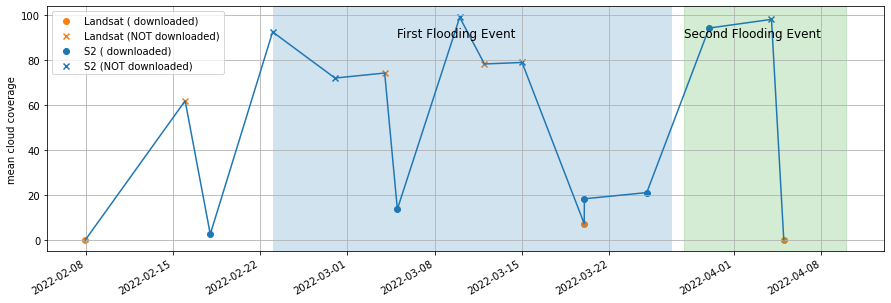

In [43]:
from itertools import product
fig, ax = plt.subplots(1,1,figsize=(15,5))

for c,downloaded in product(["Landsat","S2"], [True, False]):
    label=f"{c} ({'' if downloaded else 'NOT'} downloaded)"
    selection_iter = (metadata.satellite == c) & (metadata.s2available == downloaded)
    color = "C0" if c =="S2" else "C1"
    marker = "o" if downloaded else "x"
    ax.scatter(x=metadata[selection_iter].datetime,y=metadata[selection_iter].cloud_probability, 
               label=label,c=color,marker=marker)

ax.legend()
metadata.plot(x="datetime",y="cloud_probability",ax=ax,legend=None)
ax.axvspan(flooding_date_first_period_start_dt, flooding_date_first_period_end_dt, alpha=0.2)
ax.axvspan(flooding_date_second_period_start_dt, flooding_date_second_period_end_dt, alpha=0.2,color="C2")

ax.text(flooding_date_first_period_start_dt + timedelta(days=10), 90, "First Flooding Event", fontsize=12)
ax.text(flooding_date_second_period_start_dt, 90, "Second Flooding Event", fontsize=12)
# for d in [flooding_date_first_period_start, flooding_date_first_period_end,flooding_date_second_period_start,flooding_date_second_period_end]:
#     plt.vlines(x=datetime.strptime(d,"%Y-%m-%d"),ymin=-1,ymax=101,colors="black",linestyles="dashed")
    
plt.ylabel("mean cloud coverage")
plt.xlabel("")
plt.grid()

### Plot processed floodmaps

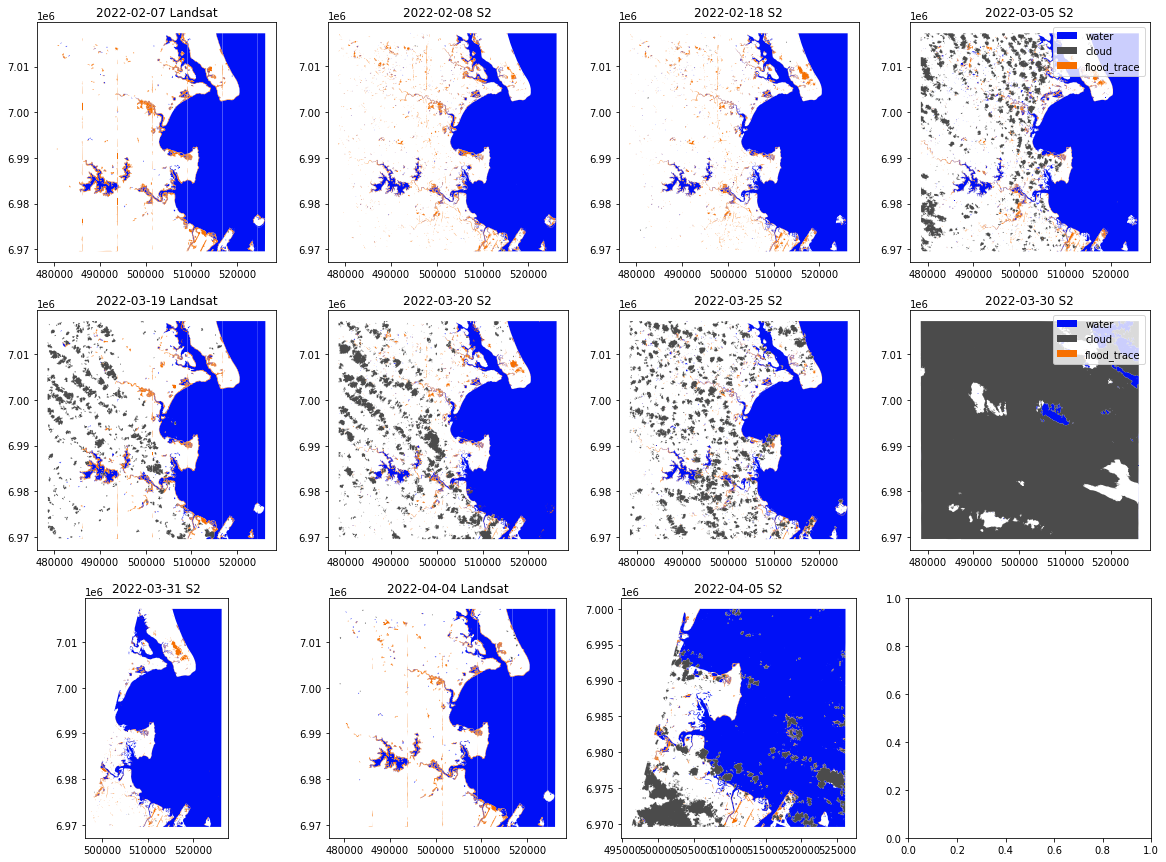

In [44]:
import matplotlib.pyplot as plt
from math import ceil

fig, ax =plt.subplots(ceil(len(geojsons)/ 4),4,
                      figsize=(20,ceil(len(geojsons)/ 4)*5))

ax = ax.flatten()

for idx,g in enumerate(geojsons):
    date = os.path.splitext(os.path.basename(g))[0]
    satellite = os.path.basename(os.path.dirname(g))
    floodmap = utils.read_geojson_from_gcp(g)
    plot_utils.plot_floodmap(floodmap, ax=ax[idx],legend=(idx%4)==3)
    ax[idx].set_title(f"{date} {satellite}")

## Step 2: Get the water content before the flooding

In [45]:
from ml4floods.models import postprocess

floodmaps_pre = [g for g in geojsons if os.path.splitext(os.path.basename(g))[0] < flooding_date_pre]
print(f"Floodmaps to process before the flooding: {[os.path.basename(g)[0] for g in floodmaps_pre]}")
data_pre = postprocess.get_floodmap_pre(floodmaps_pre,verbose=True)
data_pre

Floodmaps to process before the flooding: ['2', '2', '2']


,class,geometry
0,water,"POLYGON ((495480.000 6979530.000, 495510.000 6..."
1,water,"POLYGON ((485790.000 6982470.000, 485790.000 6..."
2,water,"POLYGON ((498750.000 6983190.000, 498990.000 6..."
4,water,"POLYGON ((498060.000 6983190.000, 498000.000 6..."
5,water,"POLYGON ((498780.000 6983250.000, 498690.000 6..."
...,...,...
166,water,"POLYGON ((518250.000 7009410.000, 518280.000 7..."
167,water,"POLYGON ((526170.000 7017260.000, 526200.000 7..."
168,water,"POLYGON ((516630.000 7013220.000, 516630.000 7..."
169,cloud,"POLYGON ((518100.000 6973800.000, 518100.000 6..."


<AxesSubplot:>

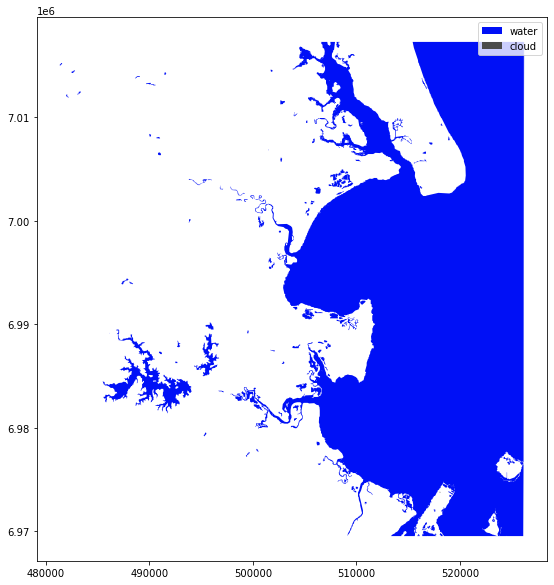

In [46]:
plot_utils.plot_floodmap(data_pre)

## Step 3: Get the water content after the first flooding event

In [47]:
floodmaps_post_first_list = [g for g in geojsons if (os.path.splitext(os.path.basename(g))[0] >= flooding_date_first_period_start) and (os.path.splitext(os.path.basename(g))[0] < flooding_date_first_period_end)]
floodmaps_post_first_list

['gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-03-05.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/Landsat/2022-03-19.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-03-20.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-03-25.geojson']

In [48]:
%%time

data_post_first_period = postprocess.get_floodmap_post(floodmaps_post_first_list,verbose=True)
data_post_first_period

CPU times: user 13.6 s, sys: 46.6 ms, total: 13.6 s
Wall time: 15.3 s


,class,geometry
0,flood_trace,"POLYGON ((484220.000 6970540.000, 484240.000 6..."
1,flood_trace,"POLYGON ((486440.000 6971420.000, 486460.000 6..."
2,flood_trace,"POLYGON ((486440.000 6971720.000, 486440.000 6..."
3,flood_trace,"POLYGON ((486700.000 6971700.000, 486720.000 6..."
4,flood_trace,"POLYGON ((482180.000 6972420.000, 482180.000 6..."
...,...,...
2926,cloud,"POLYGON ((493936.667 7002630.000, 493900.000 7..."
2927,cloud,"POLYGON ((492400.000 7006610.000, 492440.000 7..."
2928,cloud,"POLYGON ((492432.000 7006926.000, 492420.000 7..."
2929,cloud,"POLYGON ((499440.000 7017265.607, 498930.000 7..."


<AxesSubplot:>

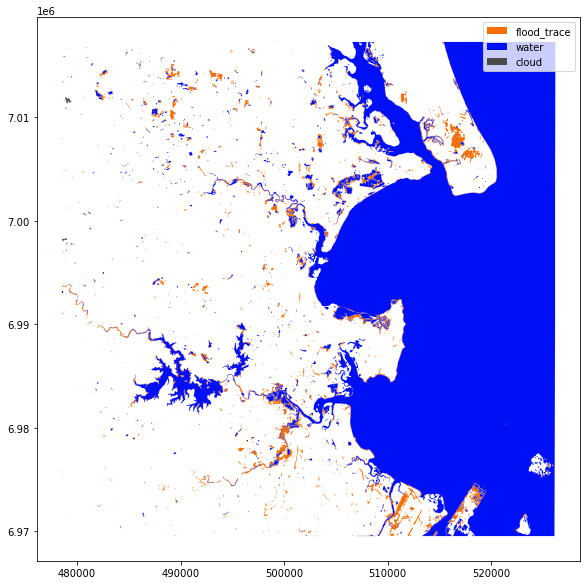

In [49]:
plot_utils.plot_floodmap(data_post_first_period)

### Plot the difference between pre and post flood observed water

In [50]:
prepost_map = postprocess.compute_flood_water(floodmap_post_data=data_post_first_period, best_pre_flood_data=data_pre)
prepost_map

,class,geometry
0,water-pre-flood,"POLYGON ((495480.000 6979530.000, 495510.000 6..."
1,water-pre-flood,"POLYGON ((485790.000 6982470.000, 485790.000 6..."
2,water-pre-flood,"POLYGON ((498750.000 6983190.000, 498990.000 6..."
3,water-pre-flood,"POLYGON ((498060.000 6983190.000, 498000.000 6..."
4,water-pre-flood,"POLYGON ((498780.000 6983250.000, 498690.000 6..."
...,...,...
5293,water-post-flood,"POLYGON ((516600.000 7013350.000, 516580.000 7..."
5294,water-post-flood,"POLYGON ((516640.000 7013220.000, 516640.000 7..."
5295,water-post-flood,"POLYGON ((516380.000 7013680.000, 516380.000 7..."
5296,water-post-flood,"POLYGON ((516570.000 7013200.000, 516570.000 7..."


<AxesSubplot:>

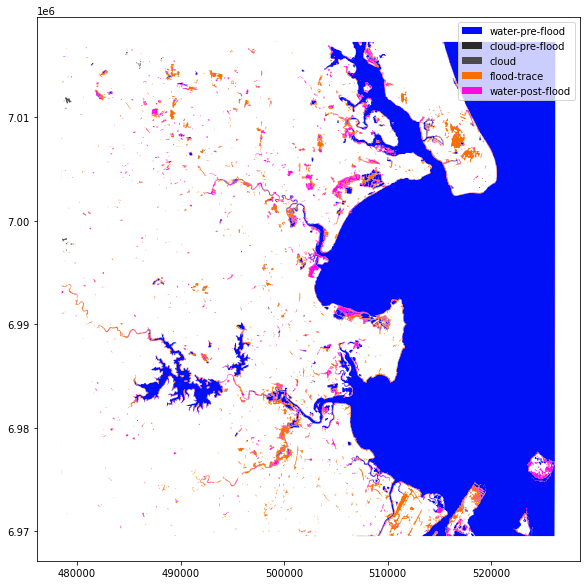

In [51]:
plot_utils.plot_floodmap(prepost_map)

## Step 4: Get the water content after the second flooding event

In [52]:
floodmaps_post_second_list = [g for g in geojsons if (os.path.splitext(os.path.basename(g))[0] >= flooding_date_second_period_start) and (os.path.splitext(os.path.basename(g))[0] < flooding_date_second_period_end)]
floodmaps_post_second_list

['gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-03-30.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-03-31.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/Landsat/2022-04-04.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/QLAOI03/WF2_unet_rbgiswirs_vec/S2/2022-04-05.geojson']

In [53]:
data_post_second_period = postprocess.get_floodmap_post(floodmaps_post_second_list,verbose=True)
data_post_second_period

,class,geometry
0,flood_trace,"POLYGON ((492660.000 6969570.000, 491460.000 6..."
1,flood_trace,"POLYGON ((486119.693 6969581.341, 485287.698 6..."
2,flood_trace,"POLYGON ((493320.000 6969630.000, 493650.000 6..."
3,flood_trace,"POLYGON ((493740.000 6971280.000, 493770.000 6..."
4,flood_trace,"POLYGON ((486150.000 6971850.000, 486150.000 6..."
...,...,...
1432,cloud,"POLYGON ((517890.000 6973780.000, 517900.000 6..."
1433,cloud,"POLYGON ((493800.000 6997590.000, 493830.000 6..."
1434,cloud,"POLYGON ((503340.000 7012200.000, 503430.000 7..."
1435,cloud,"POLYGON ((499380.000 7015890.000, 499170.000 7..."


<AxesSubplot:>

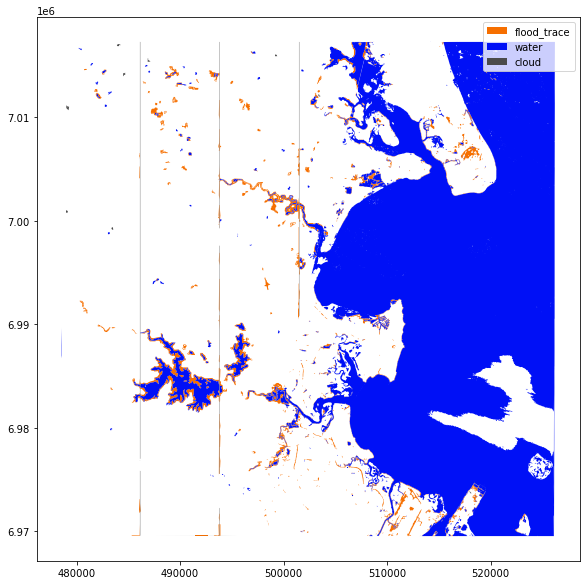

In [54]:
plot_utils.plot_floodmap(data_post_second_period)

### Compute the difference between pre and post flood observed water

In [55]:
prepost_map_second = postprocess.compute_flood_water(floodmap_post_data=data_post_second_period, best_pre_flood_data=data_pre)
prepost_map_second

,class,geometry
0,water-pre-flood,"POLYGON ((495480.000 6979530.000, 495510.000 6..."
1,water-pre-flood,"POLYGON ((485790.000 6982470.000, 485790.000 6..."
2,water-pre-flood,"POLYGON ((498750.000 6983190.000, 498990.000 6..."
3,water-pre-flood,"POLYGON ((498060.000 6983190.000, 498000.000 6..."
4,water-pre-flood,"POLYGON ((498780.000 6983250.000, 498690.000 6..."
...,...,...
3577,water-post-flood,"POLYGON ((524200.000 6977100.000, 524200.000 6..."
3578,water-post-flood,"POLYGON ((524310.000 6977200.000, 524360.000 6..."
3579,water-post-flood,"POLYGON ((524640.000 6976920.000, 524610.000 6..."
3580,water-post-flood,"POLYGON ((524120.000 6977000.000, 524150.000 6..."


<AxesSubplot:>

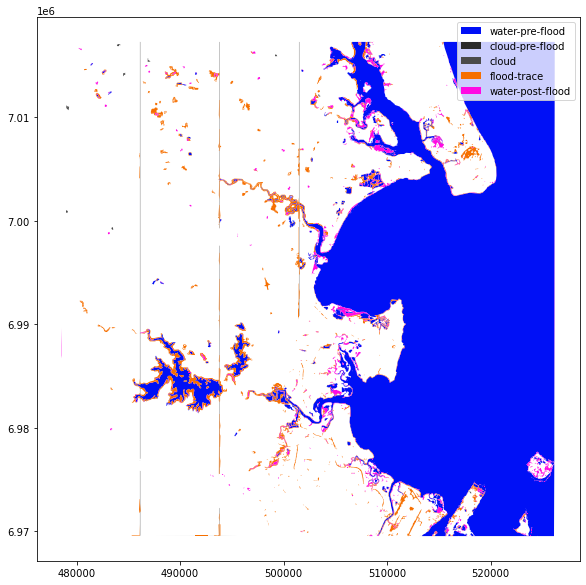

In [56]:
plot_utils.plot_floodmap(prepost_map_second)